# House Classifier

Group:
- Amanda Alves Guimarães
- Pietro Masur

The house classifier will tell you if the image you uploaded contains either a castle, an igloo or a hut.

First of all, we must install the packages we need to execute this notebook.

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.4MB/s 
     |████████████████████████████████| 194kB 10.7MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 11.8MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Now, we need to insert the key and download the images.

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e6c303f4168e494b81536613658455fc')

In [ ]:
results = search_images_bing(key, 'castle')
imsCastle = results.attrgot('content_url')
len(imsCastle)

150

In [ ]:
ims = ['https://th.bing.com/th/id/OIP.O-5gAsLHl8ZkrBjXYP22bgHaFc?pid=ImgDet&rs=1']

In [ ]:
import os
os.mkdir('images') #if you are running this notebook for the second time, you need to delete this line.
dest = 'images/castle.jpg'
download_url(ims[0], dest)

In [ ]:
houses_types = 'castle','igloo','hut'
path = Path('houses')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in houses_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#425) [Path('houses/igloo/00000055.jpeg'),Path('houses/igloo/00000025.jpg'),Path('houses/igloo/00000144.jpg'),Path('houses/igloo/00000084.jpg'),Path('houses/igloo/00000040.jpg'),Path('houses/igloo/00000056.jpg'),Path('houses/igloo/00000036.jpg'),Path('houses/igloo/00000121.jpg'),Path('houses/igloo/00000002.jpg'),Path('houses/igloo/00000009.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#8) [Path('houses/igloo/00000106.jpg'),Path('houses/igloo/00000135.jpg'),Path('houses/hut/00000063.jpg'),Path('houses/castle/00000107.JPG'),Path('houses/castle/00000073.jpg'),Path('houses/castle/00000104.jpg'),Path('houses/castle/00000033.jpg'),Path('houses/castle/00000097.jpg')]

In [ ]:
failed.map(Path.unlink);

In [ ]:
houses = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = houses.dataloaders(path)


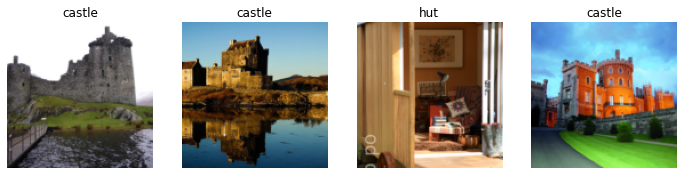

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

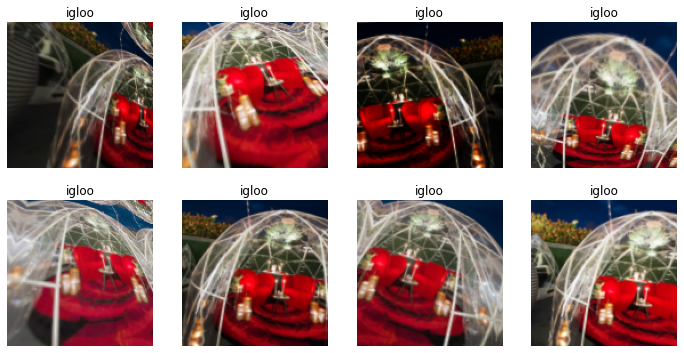

In [ ]:
houses = houses.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = houses.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
houses = houses.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = houses.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate) 
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.640187,0.280281,0.132530,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.373299,0.076845,0.024096,00:15
1,0.222840,0.096022,0.024096,00:16
2,0.163954,0.116555,0.024096,00:16
3,0.120444,0.115410,0.024096,00:15


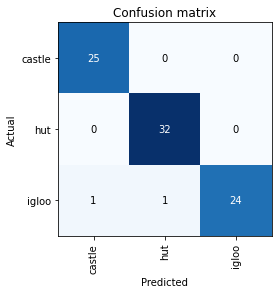

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

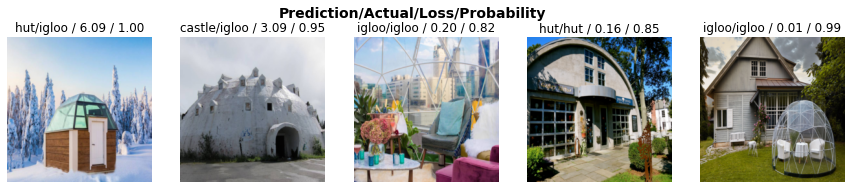

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

We improved the model using the techniques from chapter 5.




In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)


epoch,train_loss,valid_loss,error_rate,time
0,0.489296,8.323894,0.216867,00:16


epoch,train_loss,valid_loss,error_rate,time
0,6.097777,17284.720703,0.698795,00:15


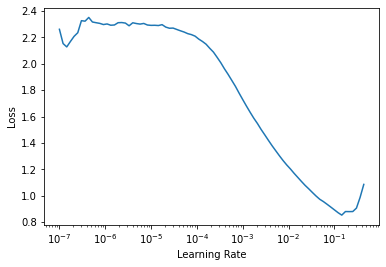

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.45e-02, steepest point: 6.92e-04


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.334561,0.373013,0.120482,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.242738,0.065135,0.024096,00:15
1,0.139508,0.064907,0.024096,00:16


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.425641,0.237726,0.108434,00:16
1,0.755267,0.091803,0.024096,00:15
2,0.492994,0.090343,0.036145,00:15


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=6.309573450380412e-07)

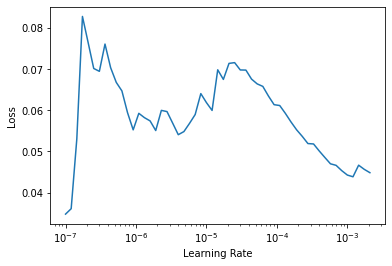

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.066545,0.059308,0.024096,00:16
1,0.057271,0.091245,0.024096,00:16
2,0.045630,0.088662,0.024096,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(1, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.170750,0.407326,0.156627,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.234159,0.203925,0.060241,00:16
1,0.222623,0.146367,0.048193,00:16
2,0.202485,0.113333,0.036145,00:16
3,0.190068,0.094906,0.036145,00:16
4,0.177302,0.078575,0.036145,00:16
5,0.165326,0.068881,0.012048,00:16
6,0.152230,0.067014,0.012048,00:15
7,0.140431,0.067126,0.024096,00:16
8,0.130011,0.067621,0.024096,00:16
9,0.126081,0.067123,0.024096,00:15


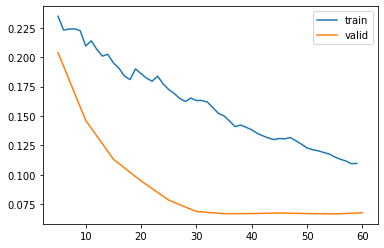

In [ ]:
learn.recorder.plot_loss()

Now we are going to export our model.

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('houses/castle/00000000.jpg')

('castle', tensor(0), tensor([1.0000e+00, 1.5640e-06, 2.5523e-07]))

In [ ]:
learn_inf.dls.vocab

['castle', 'hut', 'igloo']

In [ ]:
btn_upload = widgets.FileUpload()
##btn_upload

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
##with out_pl: display(img.to_thumb(128,128))
##out_pl

In [ ]:
##pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
##lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
##lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
##btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

The widgets:

In [ ]:
VBox([widgets.Label('Select your house!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

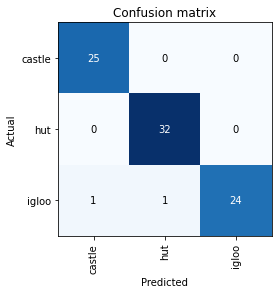

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()